# Variability & Conditional Selection

In the previous notebook, we looked at Climatologies (Means) and Anomalies. However, deeper analysis often requires looking at the **Variability** (Standard Deviation) and isolating specific physical regimes (Conditional Selection).

### Objectives
1.  **Temporal Standard Deviation:** Quantifying how much the climate system fluctuates over time. This is crucial for verifying if a model captures the correct amplitude of weather/climate events (like El Niño).
2.  **Conditional Selection (Masking):** Selecting data in one variable based on the state of another. For example, *"What is the Earth's Albedo only when it is cloudy?"* This allows for **Process-Oriented Validation**.

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Load the datasets
# We will use OLR for variability
ds_olr = xr.open_dataset('Datasets/CERES_TOA_OutgoingLW.nc')
olr = ds_olr.toa_lw_all_mon

# We will use Albedo and Cloud Fraction for conditional selection
ds_sw_out = xr.open_dataset('Datasets/CERES_TOA_OutgoingSW.nc')
ds_sw_in = xr.open_dataset('Datasets/CERES_TOA_IncomingSW.nc')
ds_cld = xr.open_dataset('Datasets/CERES_CLD_AreaPercent.nc')

# Calculate Albedo (Reflected / Incoming)
albedo = ds_sw_out.toa_sw_all_mon / ds_sw_in.solar_mon
cld_frac = ds_cld.cldarea_total_daynight_mon

## Standard Deviation over Time

The Mean state tells us about the "Climate," but the Standard Deviation tells us about the "Weather" or "Dynamics."

We use `.std(dim='time')` to collapse the time dimension, leaving us with a map where bright colors indicate regions of high instability or variability.

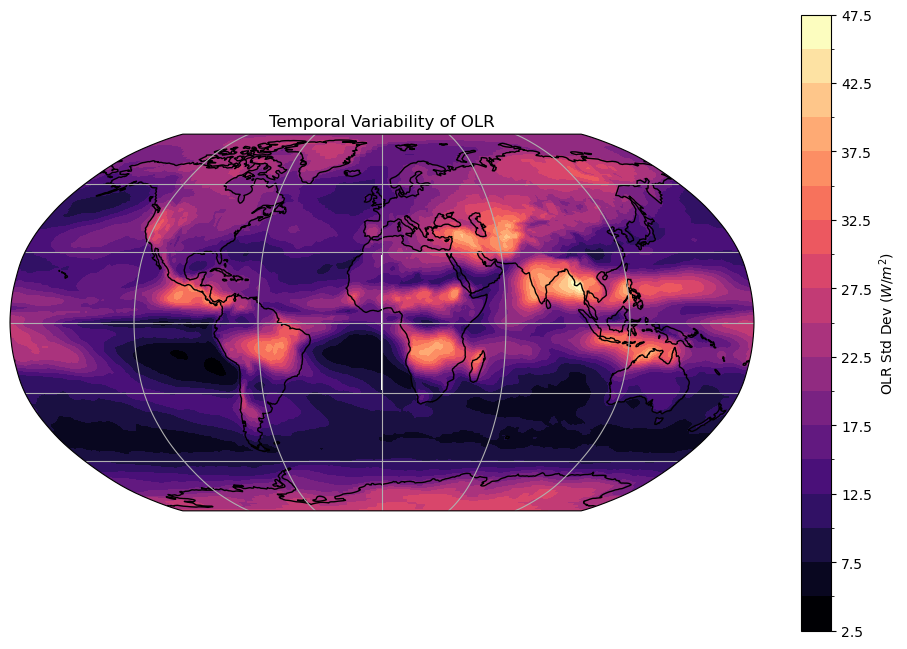

In [4]:
# Calculate the Temporal Standard Deviation
olr_std = olr.std(dim='time')

# Plot the Variability Map
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.Robinson())

olr_std.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), 
                      levels=20, cmap='magma', 
                      cbar_kwargs={'label': 'OLR Std Dev ($W/m^2$)'})

ax.coastlines()
ax.gridlines()
plt.title("Temporal Variability of OLR")
plt.show()

## Conditional Selection: Masking one dataset with another

A powerful feature of `xarray` is the ability to filter Data A based on values in Data B. This is done using `.where()`.

### The Question: "What is the Albedo of the Earth... but only where it is cloudy?"
This helps us separate the reflectivity of **Clouds** from the reflectivity of **Ice/Desert**.

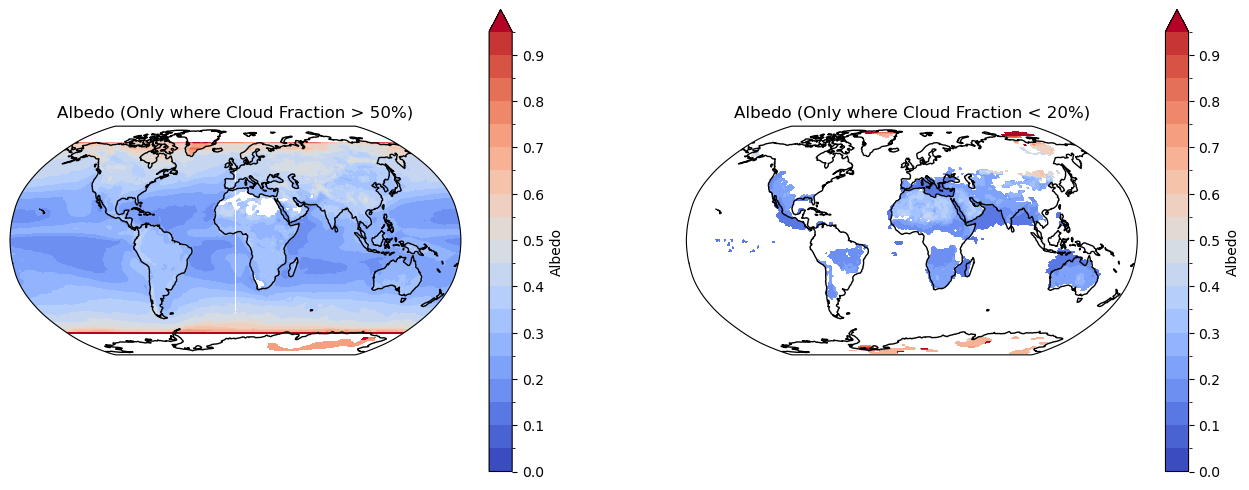

In [10]:
# Define a condition: "Cloudy" means Cloud Fraction > 50%
# Xarray automatically aligns the time, lat, and lon coordinates of cld_frac with albedo
condition = cld_frac > 50

# Apply the mask
# Where the condition is False, the data becomes NaN (Not a Number)
albedo_cloudy_only = albedo.where(condition)

# Let's also look at "Clear Sky" regions (Cloud Fraction < 20%)
albedo_clear_only = albedo.where(cld_frac < 20)

# Plotting Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), subplot_kw={'projection': ccrs.Robinson()})

# Plot Cloudy Albedo
albedo_cloudy_only.mean(dim='time').plot.contourf(ax=ax1, transform=ccrs.PlateCarree(),
                                                  levels=np.arange(0, 1, 0.05), cmap='coolwarm',
                                                  cbar_kwargs={'label': 'Albedo'})
ax1.set_title("Albedo (Only where Cloud Fraction > 50%)")
ax1.coastlines()

# Plot Clear Sky Albedo
albedo_clear_only.mean(dim='time').plot.contourf(ax=ax2, transform=ccrs.PlateCarree(),
                                                 levels=np.arange(0, 1, 0.05), cmap='coolwarm',
                                                 cbar_kwargs={'label': 'Albedo'})
ax2.set_title("Albedo (Only where Cloud Fraction < 20%)")
ax2.coastlines()

plt.show()